# Modeling - Transfer learning with MobileNetV2

In [1]:
# Import libraries
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras
sns.set(context='talk')

TensorFlow 2.x selected.


## Data preprocessing

In [2]:
# Mount Google Drive where data is located
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Unzip data
!unzip '/content/drive/My Drive/data.zip'

Archive:  /content/drive/My Drive/data.zip
   creating: data/
   creating: data/train/
   creating: data/train/bak_chor_mee/
  inflating: data/train/bak_chor_mee/0000f56e768f0210598c26d059cc9b56eb72d3d2.jpg  
  inflating: data/train/bak_chor_mee/002b67377afbd1d13a99164cda2de8abbb7824cb.jpg  
  inflating: data/train/bak_chor_mee/004ea44897fb1035d148ac8964e629ad4a6d172e.jpg  
  inflating: data/train/bak_chor_mee/007b766a6e28835fbd9ab57a6ee5230bd70e8d29.jpg  
  inflating: data/train/bak_chor_mee/00a9c72be1b309c4c39891717d5e92bf0202f442.jpg  
  inflating: data/train/bak_chor_mee/00c3b42696ad8d70c2ac47795f271b8a9e169d3c.jpg  
  inflating: data/train/bak_chor_mee/00cae12ec6e92d55cf2fc637fd6de6fee1b14c46.jpg  
  inflating: data/train/bak_chor_mee/00dfa7802daa6b266f5eb3934ea319e4c69bac69.jpg  
  inflating: data/train/bak_chor_mee/00e8c7415156efde87ecc5fee5b6253aa11f02bc.jpg  
  inflating: data/train/bak_chor_mee/015f45763282b9bbe017c5253e5815e27a15c152.jpg  
  inflating: data/train/bak_chor_me

In [0]:
# Format images for classification: all images will be resized to 224x224
img_width, img_height = 224, 224 
train_data_dir = './data/train'
validation_data_dir = './data/validation'
batch_size = 32
num_train = 13200
num_validation = 3300

In [5]:
# Data augmentation configuration for train data
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

# Data augmentation configuration for test data: only rescaling
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255)

# Generator that reads pictures found in subfolers of 'data/train'
# and indefinitely generate batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Similar generator for validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Map index to class names
classes = dict((v, k.replace('_', ' ').title()) for k, v in train_generator.class_indices.items())

Found 13200 images belonging to 11 classes.
Found 3300 images belonging to 11 classes.


## Create base model from pre-trained network

In [6]:
# Create base model from pre-trained MobileNetV2 model
base_model = keras.applications.MobileNetV2(input_shape=(img_width, img_height, 3),
                                            include_top=False,
                                            weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


## Feature extraction

In [0]:
# Freeze convolutional base to prevent weights from being updated during training
base_model.trainable = False

In [8]:
# Examine the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
# Define model structure
model = keras.Sequential([base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(11, activation='softmax')])

In [0]:
# Compile model
top3_acc = keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy')
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', top3_acc])

In [11]:
# Examine model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                14091     
Total params: 2,272,075
Trainable params: 14,091
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
initial_epochs = 100

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False)

# Train model with early stopping
history = model.fit_generator(
    train_generator,
    epochs=initial_epochs,
    steps_per_epoch=num_train // batch_size,
    validation_data=validation_generator,
    validation_steps=num_validation // batch_size,
    callbacks=[callback])

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
412/412 [==============================] - 253s 614ms/step - loss: 1.8363 - accuracy: 0.4224 - top_3_categorical_accuracy: 0.6773 - val_loss: 1.5147 - val_accuracy: 0.5352 - val_top_3_categorical_accuracy: 0.8028
Epoch 2/100
412/412 [==============================] - 246s 598ms/step - loss: 1.0244 - accuracy: 0.7538 - top_3_categorical_accuracy: 0.9275 - val_loss: 1.1714 - val_accuracy: 0.6620 - val_top_3_categorical_accuracy: 0.8744
Epoch 3/100
412/412 [==============================] - 246s 597ms/step - loss: 0.7538 - accuracy: 0.8136 - top_3_categorical_accuracy: 0.9564 - val_loss: 1.0401 - val_accuracy: 0.7024 - val_top_3_categorical_accuracy: 0.8914
Epoch 4/100
412/412 [==============================] - 247s 600ms/step - loss: 0.6224 - accuracy: 0.8420 - top_3_categorical_accuracy: 0.9619 - val_loss: 0.9931 - val_accuracy: 0.7115 - val_top_3_categorical_accuracy: 0.8947
Epoch 

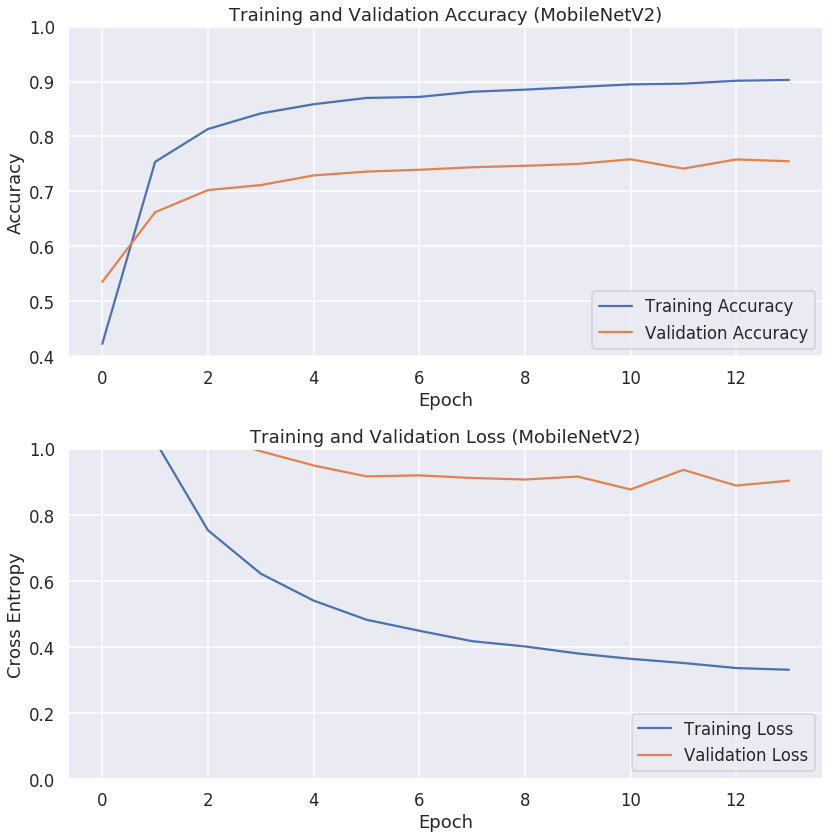

In [13]:
# Plot learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12), facecolor='white')
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy (MobileNetV2)')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss (MobileNetV2)')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

## Fine tuning

In [14]:
# Fine tuning: unfreeze top layers of base model
base_model.trainable = True

# Examine how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [15]:
# Compile the model using a much lower training rate
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate/10),
              loss='categorical_crossentropy',
              metrics=['accuracy', top3_acc])

# Examine model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                14091     
Total params: 2,272,075
Trainable params: 1,876,683
Non-trainable params: 395,392
_________________________________________________________________


In [16]:
first_epochs = len(history.history['val_loss'])

fine_tune_epochs = 100
total_epochs =  first_epochs + fine_tune_epochs

# Continue model training with early stopping
history_fine = model.fit_generator(
    train_generator,
    epochs=total_epochs,
    initial_epoch = first_epochs,
    steps_per_epoch=num_train // batch_size,
    validation_data=validation_generator,
    validation_steps=num_validation // batch_size,
    callbacks=[callback])

Epoch 15/114
412/412 [==============================] - 260s 631ms/step - loss: 0.2662 - accuracy: 0.9195 - top_3_categorical_accuracy: 0.9882 - val_loss: 0.5169 - val_accuracy: 0.8401 - val_top_3_categorical_accuracy: 0.9578
Epoch 16/114
412/412 [==============================] - 258s 627ms/step - loss: 0.1819 - accuracy: 0.9433 - top_3_categorical_accuracy: 0.9937 - val_loss: 0.3806 - val_accuracy: 0.8783 - val_top_3_categorical_accuracy: 0.9794
Epoch 17/114
412/412 [==============================] - 249s 605ms/step - loss: 0.1422 - accuracy: 0.9574 - top_3_categorical_accuracy: 0.9957 - val_loss: 0.3158 - val_accuracy: 0.8993 - val_top_3_categorical_accuracy: 0.9870
Epoch 18/114
412/412 [==============================] - 252s 611ms/step - loss: 0.1202 - accuracy: 0.9635 - top_3_categorical_accuracy: 0.9968 - val_loss: 0.2758 - val_accuracy: 0.9075 - val_top_3_categorical_accuracy: 0.9888
Epoch 19/114
412/412 [==============================] - 252s 612ms/step - loss: 0.0975 - accurac

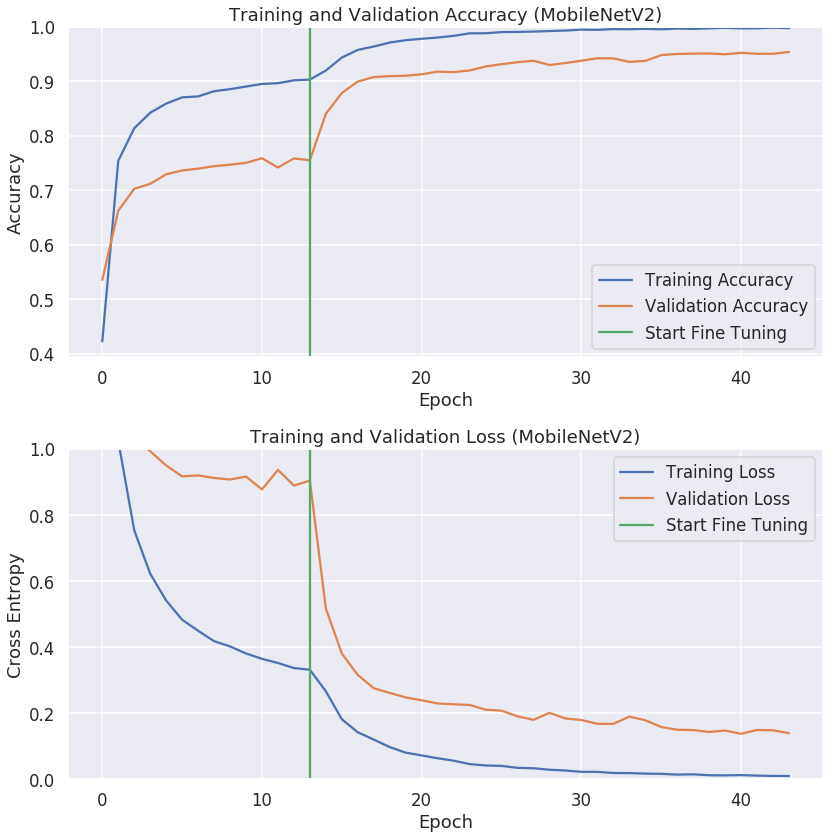

In [17]:
# Plot learning curves
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(12, 12), facecolor='white')
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([first_epochs-1,first_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (MobileNetV2)')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([first_epochs-1,first_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss (MobileNetV2)')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [0]:
# Save TensorFlow model
model.save('/content/drive/My Drive/model_net.h5')

## Prediction and evaluation

In [0]:
# Load trained model
model = keras.models.load_model('/content/drive/My Drive/model_net.h5')

Text(10, 10, 'Nasi Lemak\n0.99992156')

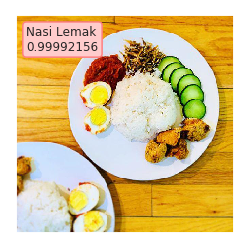

In [20]:
# Load random image from validation set
x_batch = next(validation_generator)
example_img = x_batch[0][0]

# Make prediction
input_vector = np.expand_dims(example_img,0).astype(np.float32)
img_predict = model.predict(input_vector)[0]
img_class = classes[np.argmax(img_predict)]
img_proba = max(img_predict)

# Plot image with predicted class
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(example_img)
plt.text(10, 10, '{}\n{}'.format(img_class, str(img_proba)), size=12,
         ha="left", va="top",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8)))

In [21]:
# Add additional parameters to validation data generator to
# ensure reproducibility when getting predicted and true values
class_validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42)

Found 3300 images belonging to 11 classes.


In [0]:
# Obtain predicted and true values from validation data
class_validation_generator.reset()
predictions = model.predict_generator(class_validation_generator)
y_true = class_validation_generator.classes
y_pred = np.argmax(predictions, axis=1)

In [23]:
# Generate report showing classification metrics:
# precision, recall and f1 score
from sklearn.metrics import classification_report
report_dict = classification_report(y_true, y_pred, target_names=list(classes.values()), output_dict=True)
print(classification_report(y_true, y_pred, target_names=list(classes.values())))

                   precision    recall  f1-score   support

     Bak Chor Mee       0.91      0.92      0.92       300
      Bak Kut Teh       0.98      0.99      0.99       300
   Char Kway Teow       0.99      0.93      0.96       300
     Chicken Rice       0.92      0.96      0.94       300
Fried Hokkien Mee       0.94      0.97      0.96       300
            Laksa       0.92      0.99      0.95       300
       Nasi Lemak       0.97      0.88      0.92       300
         Non Food       1.00      0.95      0.97       300
       Roti Prata       0.99      0.99      0.99       300
            Satay       0.99      0.96      0.97       300
       Wanton Mee       0.89      0.96      0.92       300

         accuracy                           0.95      3300
        macro avg       0.96      0.95      0.95      3300
     weighted avg       0.96      0.95      0.95      3300



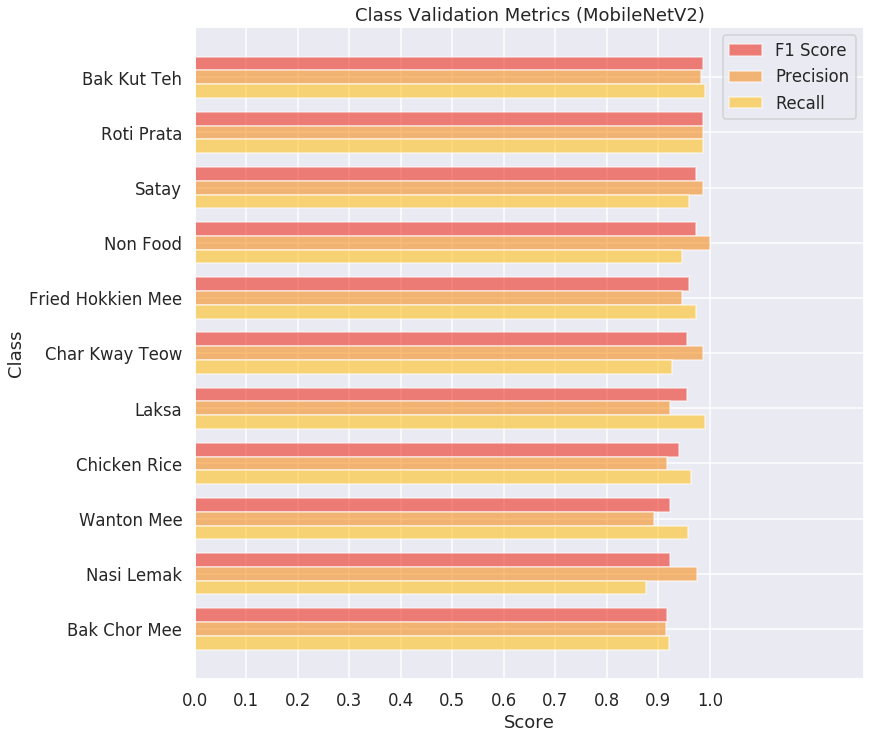

In [24]:
# Plot class validation metrics
df_plot = pd.DataFrame(report_dict).T.drop(index=['accuracy','macro avg', 'weighted avg']).sort_values(by='f1-score')

pos = np.arange(len(df_plot['f1-score']))
height = 0.25
fig, ax = plt.subplots(figsize=(12,12))

plt.barh(pos,
         width=df_plot['f1-score'],
         height=height,
         alpha=0.6,
         color='#EE3224')

plt.barh([p - height for p in pos],
         width=df_plot['precision'],
         height=height,
         alpha=0.6,
         color='#F78F1E')

plt.barh([p - height*2 for p in pos],
         width=df_plot['recall'],
         height=height,
         alpha=0.6,
         color='#FFC222')

ax.set_title('Class Validation Metrics (MobileNetV2)')
ax.set_xlabel('Score')
ax.set_ylabel('Class')
ax.set_yticklabels(df_plot.index)
ax.set_yticks([p - 1 * height for p in pos])
ax.set_xlim([0, 1.3])
ax.set_xticks(np.arange(0, 1.01, step=0.1))
plt.legend(['F1 Score', 'Precision', 'Recall'], loc='upper right')
plt.show()